In [114]:
# get the Dataset:

import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import scipy.io as sio

t0 = time.time()

mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/BCI.mat')

X = mat_contents['X']
Y = mat_contents['Z']
print('X.shape', X.shape)
print('Y.shape', Y.shape)

# verify that the model REALLY finds a mapping between the input and the labels. If we get
# our accuracy by chance, then we should get the same accuracy on a permuted dataset:
# Y = np.random.permutation(Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.50)
print('Original data type:', x_train.dtype)

# convert to float64 for numerical stability:
x_train = x_train.astype('float64')
y_train = y_train.astype('float64')
x_test = x_test.astype('float64')
y_test = y_test.astype('float64')

# normalize to unit variance and zero mean: (by the way, it kills the learning for some reason)
# for j in range(3):
#     for i in range(x_train.shape[0]):
#         x_train[i,:,:,j] = preprocessing.scale(x_train[i,:,:,j], axis=1)
#         x_train[i,:,:,j] = preprocessing.minmax_scale(x_train[i,:,:,j], axis=1)

#     for i in range(x_test.shape[0]):
#         x_test[i,:,:,j] = preprocessing.scale(x_test[i,:,:,j], axis=1)
#         x_test[i,:,:,j] = preprocessing.minmax_scale(x_test[i,:,:,j], axis=1)

# # ensure the tensors are sized right:
# x_train = np.transpose(x_train,(0,2,1))
# x_test = np.transpose(x_test,(0,2,1))

# one hot encode the labels:
onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
y_train = onehot_encoder.fit_transform(y_train)
y_test = onehot_encoder.fit_transform(y_test)

# convert to float16 to save space:
x_train = x_train.astype('float16')
y_train = y_train.astype('float16')
x_test = x_test.astype('float16')
y_test = y_test.astype('float16')
print('Normalized data type:', x_train.dtype)

print('test input shape', x_test.shape, "Nomralized MEAN:", np.mean(x_test), "min", np.min(x_test),"max", np.max(x_test))
print('train input shape', x_train.shape, "Nomralized MEAN:", np.mean(x_train), "min", np.min(x_train),"max", np.max(x_train))

print('test labels shape', y_test.shape, "Nomralized MEAN:", np.mean(y_test), "min", np.min(y_test),"max", np.max(y_test))
print('train labels shape', y_train.shape, "Nomralized MEAN:", np.mean(y_train), "min", np.min(y_train),"max", np.max(y_train))

# print('Window length', winsize)
# print('Step size:', stepsize)
# print('Length of trial during experiment', trial_len)
# print('Low cutoff freq.', low_cutoff)
# print('High cutoff freq.', high_cutoff)
# print('Source data file:', source)

leng = x_test.shape[1]

X.shape (160, 31, 32, 3)
Y.shape (160, 1)
Original data type: float64
Normalized data type: float16
test input shape (80, 31, 32, 3) Nomralized MEAN: 331.5 min 0.0013247 max 17072.0
train input shape (80, 31, 32, 3) Nomralized MEAN: 304.5 min 0.00088501 max 10232.0
test labels shape (80, 2) Nomralized MEAN: 0.5 min 0.0 max 1.0
train labels shape (80, 2) Nomralized MEAN: 0.5 min 0.0 max 1.0


In [115]:
######################################################################

# http://cs231n.github.io/convolutional-networks/#case
# we first define the autoencoder's architecture:

# make sure you don't hog all the video memory
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)
###################################

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Flatten, Conv1D, MaxPooling1D
from keras.layers.advanced_activations import LeakyReLU
# act = LeakyReLU(alpha=0.01)
act = 'relu'
from keras.models import Model
from keras.models import load_model
from keras.callbacks import TensorBoard, EarlyStopping, Callback
from keras import optimizers
from keras.initializers import Orthogonal as orth

import numpy as np
import matplotlib.pyplot as plt

init_num_kernels = 6
kernel_size = (3,2) # this means we're convolving more agressively in frequency domain than in time
dense_n = 10

def Encoder():
    input_img = Input(shape=(31, 32, 3))  # adapt this if using `channels_first` image
    input_norm = BatchNormalization(axis=1)(input_img)
    e1 = Conv2D(init_num_kernels, kernel_size, activation='relu', padding='same',
                                    kernel_initializer = orth(gain=1.0, seed=None))(input_norm)
    e2 = MaxPooling2D((2, 2), padding='same')(e1)
    e2b = BatchNormalization(axis=1)(e2)
    e2a = Dropout(0.1)(e2b)
    e3 = Conv2D(init_num_kernels*2, kernel_size, activation='relu', padding='same',
                                    kernel_initializer = orth(gain=1.0, seed=None))(e2a)
    e4 = MaxPooling2D((2, 2), padding='same')(e3)
    e4b = BatchNormalization(axis=1)(e4)
    e4a = Dropout(0.2)(e4b)
    e5 = Conv2D(init_num_kernels*4, kernel_size, activation='relu', padding='same',
                                    kernel_initializer = orth(gain=1.0, seed=None))(e4a)
    e6 = MaxPooling2D((2, 2), padding='same')(e5)
    e6b = BatchNormalization(axis=1)(e6)
    e6a = Dropout(0.3)(e6b)
    e7 = Conv2D(init_num_kernels*8, kernel_size, activation='relu', padding='same',
                                    kernel_initializer = orth(gain=1.0, seed=None))(e6a)
    e8 = MaxPooling2D((2, 2), padding='same')(e7)
    e9 = Dropout(0.4)(e8)
    e9b = Conv2D(init_num_kernels*16, kernel_size, activation='relu', padding='same',
                                    kernel_initializer = orth(gain=1.0, seed=None))(e9)
    e10 = Flatten()(e9b)
    e10b = BatchNormalization(axis=1)(e10)
    e11 = Dense(dense_n, activation='sigmoid',
                                     kernel_initializer = orth(gain=1.0, seed=None))(e10b)
    e12 = Dropout(0.5)(e11)
    e12b = BatchNormalization(axis=1)(e12)
    e13 = Dense(2, activation='softmax')(e12b)

    return Model(input_img, e13)

enc = Encoder()
enc.compile(loss="binary_crossentropy", optimizer="adadelta", metrics=["accuracy"])
   
enc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 31, 32, 3)         0         
_________________________________________________________________
batch_normalization_95 (Batc (None, 31, 32, 3)         124       
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 31, 32, 6)         114       
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 16, 16, 6)         0         
_________________________________________________________________
batch_normalization_96 (Batc (None, 16, 16, 6)         64        
_________________________________________________________________
dropout_80 (Dropout)         (None, 16, 16, 6)         0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 16, 16, 12)        444       
__________

In [116]:
##########################################################

# Training time!
# Try 20 epochs using batch size = 3, then switch to 4
from keras.callbacks import TensorBoard, EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=40, mode='min')

train_history = enc.fit(x_train, y_train,
                epochs=1000,
                batch_size=10,
                shuffle=True,
                validation_data=(x_test, y_test),
                callbacks=[TensorBoard(log_dir='/home/amplifier/home/CNN_stim'), early_stopping])

# save the entire model and the weights after the training:
enc.save('/home/amplifier/home/NEW_DL/models/EEGnet.h5')
enc.save_weights('/home/amplifier/home/NEW_DL/weights/EEGnet_weights.h5')

Train on 80 samples, validate on 80 samples
Epoch 1/1000
80/80 [==============================] - 1s 11ms/step - loss: 1.1692 - acc: 0.4750 - val_loss: 0.6310 - val_acc: 0.6875
Epoch 2/1000
80/80 [==============================] - 0s 2ms/step - loss: 0.8701 - acc: 0.5625 - val_loss: 0.5477 - val_acc: 0.7625
Epoch 3/1000
80/80 [==============================] - 0s 2ms/step - loss: 0.8438 - acc: 0.6000 - val_loss: 0.5011 - val_acc: 0.7500
Epoch 4/1000
80/80 [==============================] - 0s 2ms/step - loss: 0.8601 - acc: 0.6125 - val_loss: 0.4803 - val_acc: 0.7500
Epoch 5/1000
80/80 [==============================] - 0s 2ms/step - loss: 0.7420 - acc: 0.6375 - val_loss: 0.4816 - val_acc: 0.7625
Epoch 6/1000
80/80 [==============================] - 0s 2ms/step - loss: 0.5217 - acc: 0.7000 - val_loss: 0.4576 - val_acc: 0.7625
Epoch 7/1000
80/80 [==============================] - 0s 2ms/step - loss: 0.5835 - acc: 0.7500 - val_loss: 0.4231 - val_acc: 0.7750
Epoch 8/1000
80/80 [===========

80/80 [==============================] - 0s 3ms/step - loss: 0.3314 - acc: 0.8750 - val_loss: 0.4153 - val_acc: 0.8250
Epoch 124/1000
80/80 [==============================] - 0s 2ms/step - loss: 0.1856 - acc: 0.9000 - val_loss: 0.3206 - val_acc: 0.8500
Epoch 125/1000
80/80 [==============================] - 0s 3ms/step - loss: 0.1631 - acc: 0.9500 - val_loss: 0.3259 - val_acc: 0.8625
Epoch 126/1000
80/80 [==============================] - 0s 2ms/step - loss: 0.2973 - acc: 0.8625 - val_loss: 0.2612 - val_acc: 0.9125
Epoch 127/1000
80/80 [==============================] - 0s 2ms/step - loss: 0.2065 - acc: 0.9500 - val_loss: 0.3164 - val_acc: 0.8625
Epoch 128/1000
80/80 [==============================] - 0s 2ms/step - loss: 0.1941 - acc: 0.9375 - val_loss: 0.2768 - val_acc: 0.9000
Epoch 129/1000
80/80 [==============================] - 0s 2ms/step - loss: 0.1831 - acc: 0.9250 - val_loss: 0.3253 - val_acc: 0.8625
Epoch 130/1000
80/80 [==============================] - 0s 3ms/step - loss: 0

In [121]:
###########################################################

# let's predict a TRAINING sammple:
decoded_train = enc.predict(x_train)
decoded_test = enc.predict(x_test)
print(decoded_train.shape)
print(decoded_test.shape)

(80, 2)
(80, 2)


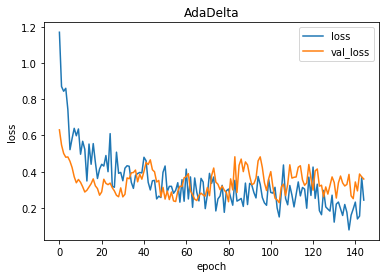

In [122]:
#####################################################

# print(np.array(history.losses))
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.title('AdaDelta')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Layer number: 2 Layer name: conv2d_81
(3, 2, 3, 6)


Text(0.5,0.98,'Convolution kernels in layer conv2d_81')

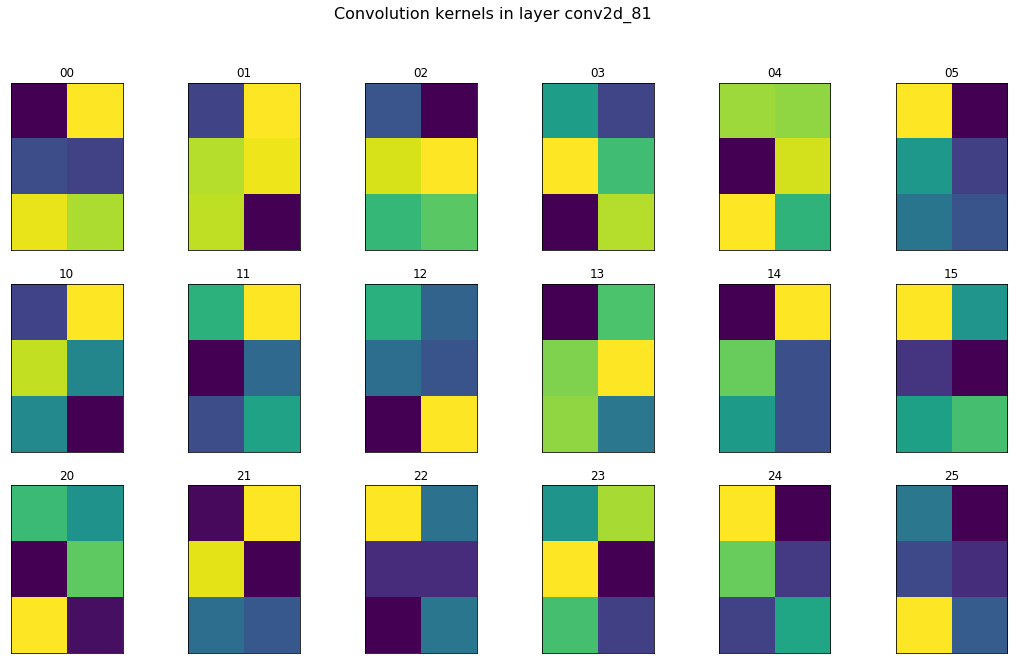

In [123]:
# Visualize a few kernels from the first convolutional layer:
# enc.layers[2].get_config()
# dir(enc.layers[2])
x = enc.layers[2].get_weights()
print ('Layer number:', 2, 'Layer name:', enc.layers[2].name)
sh = x[0].shape
print(sh) # kernel length x input channels x output channels

c = 0
fig, axs = plt.subplots(sh[2],sh[3])
fig.set_size_inches(18.5, 10.5)
axs = axs.ravel()
for i in range(sh[2]):
    for j in range(sh[3]):
        axs[c].imshow(x[0][:,:,i,j])
        axs[c].get_xaxis().set_visible(False)
        axs[c].get_yaxis().set_visible(False)        
        axs[c].set_title(str(i)+str(j))
        c = c + 1
plt.suptitle(str('Convolution kernels in layer ' + enc.layers[2].name), fontsize=16)

In [124]:
##########################################################

# now test sample by sample
cor_test = []
L = x_test.shape
for sample_no in range(x_test.shape[0]):
    pred = enc.predict(np.expand_dims(x_test[sample_no],0))
    if ((pred[0][0]<pred[0][1]) and (y_test[sample_no,0] < y_test[sample_no,1]) or
       ((pred[0][0]>pred[0][1]) & (y_test[sample_no,0] > y_test[sample_no,1]))):
        cor_test.append(1)
    else:
        cor_test.append(0)

cor_train = []
L = x_train.shape
for sample_no in range(x_train.shape[0]):
    pred = enc.predict(np.expand_dims(x_train[sample_no],0))
    if ((pred[0][0]<pred[0][1]) and (y_train[sample_no,0] < y_train[sample_no,1]) or
       ((pred[0][0]>pred[0][1]) & (y_train[sample_no,0] > y_train[sample_no,1]))):
        cor_train.append(1)
    else:
        cor_train.append(0)

# Report accuracies
print('Accuracy on the test data:', np.mean(cor_test))
print('Accuracy on the training data:', np.mean(cor_train))
t1 = time.time()
print('Elapsed', t1-t0, 'seconds')

Accuracy on the test data: 0.875
Accuracy on the training data: 1.0
Elapsed 76.21398878097534 seconds
